`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
import xarray as xr
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [3]:
def draw_SOcustom(X,Y,Z,cmap,cbar_label,title,plot_type,**kwargs):
    
    crs_plot = ccrs.SouthPolarStereo()
    crs_source = ccrs.PlateCarree()
    
    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    ax.set_title(title,fontsize=14,pad = 20)
    
    if plot_type == 'contourf':
        im = ax.contourf(X,Y,Z,kwargs['clevs'],cmap=cmap,transform=crs_source)
    elif plot_type == 'pcolormesh':
        im = ax.pcolormesh(X,Y,Z,cmap=cmap,transform=crs_source,vmin=kwargs['clims'][0],vmax=kwargs['clims'][1])
    
    cbar = plt.colorbar(im,orientation='horizontal',fraction=0.025,pad=0.05)
    cbar.set_label(cbar_label,fontsize=12)
    
#     plt.show()
    
    return fig,ax

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

def calc_PpCO2(ds):
    p = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
    insitutemp = gsw.t_from_CT(ds['so'], ds['thetao'], p)  # 0 is just a filler rn 
    results = pyco2.sys(par1=ds['talk']*1035.0,par2=ds['dissic']*1035.0,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = p, 
                        temperature = insitutemp)
    return ds['talk'].copy(data=results['pCO2_out'])

def meridionalsection(ax,da,clims=None,title=None):
    im = ax.pcolormesh(da['y'],da['lev'],da)
    if clims is not None:
        im.set_clim(clims)
    ax.set_xlim([-80,60])
    ax.invert_yaxis()
    plt.colorbar(im,ax=ax)
    ax.set_title(title)
    
def calc_sigma2(ds):
    return gsw.sigma2(ds['so'],ds['thetao'])

def meridionalsection_with_sigma2(ax,da,sigma2,clims=None,title=None):
    meridionalsection(ax,da,clims)
    ax.contour(da['y'],da['lev'],sigma2,levels=[36,36.4,36.8],colors='w')
    ax.set_title(title)

In [4]:
z_kwargs = {'consolidated': True, 'use_cftime': True}
query_2 = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id='fgco2',
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'NorESM2-LM', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat_2 = col.search(**query_2)

# print(cat.df['source_id'].unique())
dd_fgco2_old = cat_2.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [5]:
dd_fgco2 = combine_datasets(
    dd_fgco2_old,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_fgco2.keys())

['CESM2-FV2.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon']

AttributeError: 'AxesSubplot' object has no attribute 'add_feature'

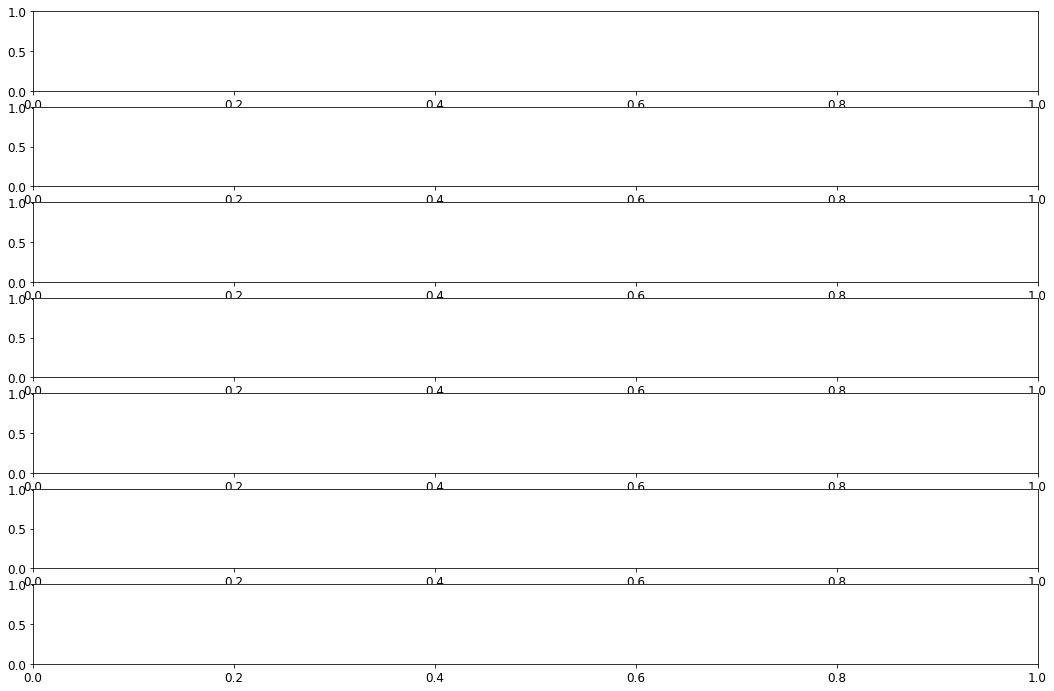

In [13]:
fig, axarr = plt.subplots(nrows = 7, figsize=[18,12])
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)


ax_idx = 0 # index for your axes array
for name, ds_fgco2 in dd_fgco2.items():
    ax = axarr.flat[ax_idx]
#     if 'member_id' in ds_fgco2.dims:
#         ds_fgco2 = ds_fgco2.isel(member_id=0)
    surf = ds_fgco2.fgco2.isel(time = 0)
#     print(surf)
    lat = ds_fgco2.lat.transpose('y','x')
#     print(lat)
    lon = ds_fgco2.lon.transpose('y','x')
    draw_SOcustom(lon.data,lat.values,surf,ax, cmap='RdBu_r',cbar_label='Surface Downward Flux of Total CO2 (kg m-2 s-1)',title=ds_fgco2.attrs['source_id']+ ' '+ds_fgco2.attrs['variant_label'],plot_type='pcolormesh',clims=[-3e-9,3e-9])
    ax_idx += 1 # this is a nifty python trick to increment a variable by one


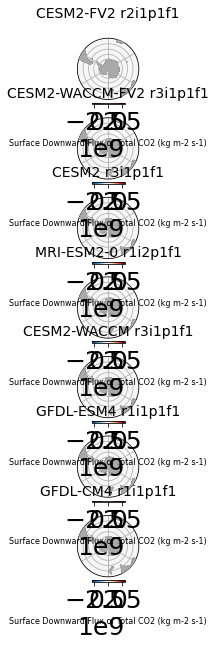

In [64]:
fig, axarr = plt.subplots(nrows = 7, figsize=[10,10],subplot_kw={'projection':ccrs.SouthPolarStereo()})
ax_idx = 0 # index for your axes array
for name, ds_fgco2 in dd_fgco2.items():
    crs_plot = ccrs.SouthPolarStereo()
    crs_source = ccrs.PlateCarree()
    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    title=ds_fgco2.attrs['source_id']+ ' '+ds_fgco2.attrs['variant_label']
    ax.set_title(title,fontsize=14,pad = 20)
    
    
    Z = ds_fgco2.fgco2.isel(time = 0)
    lat = ds_fgco2.lat.transpose('y','x')
    lon = ds_fgco2.lon.transpose('y','x')
    X = lon.data
    Y = lat.values
    
    im = ax.pcolormesh(X,Y,Z,cmap='RdBu_r',transform=crs_source,vmin=-3e9,vmax=3e9)
    
    cbar_label = 'Surface Downward Flux of Total CO2 (kg m-2 s-1)'
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction=0.025,pad=0.05)
    cbar.set_label(cbar_label, fontsize = 8)
    
    ax_idx += 1
    fig.show()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


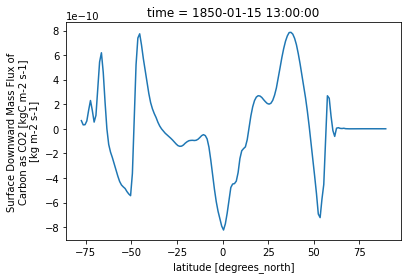

In [7]:
ds = dd_fgco2['CESM2-FV2.gr.historical.Omon']
ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True).plot()


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

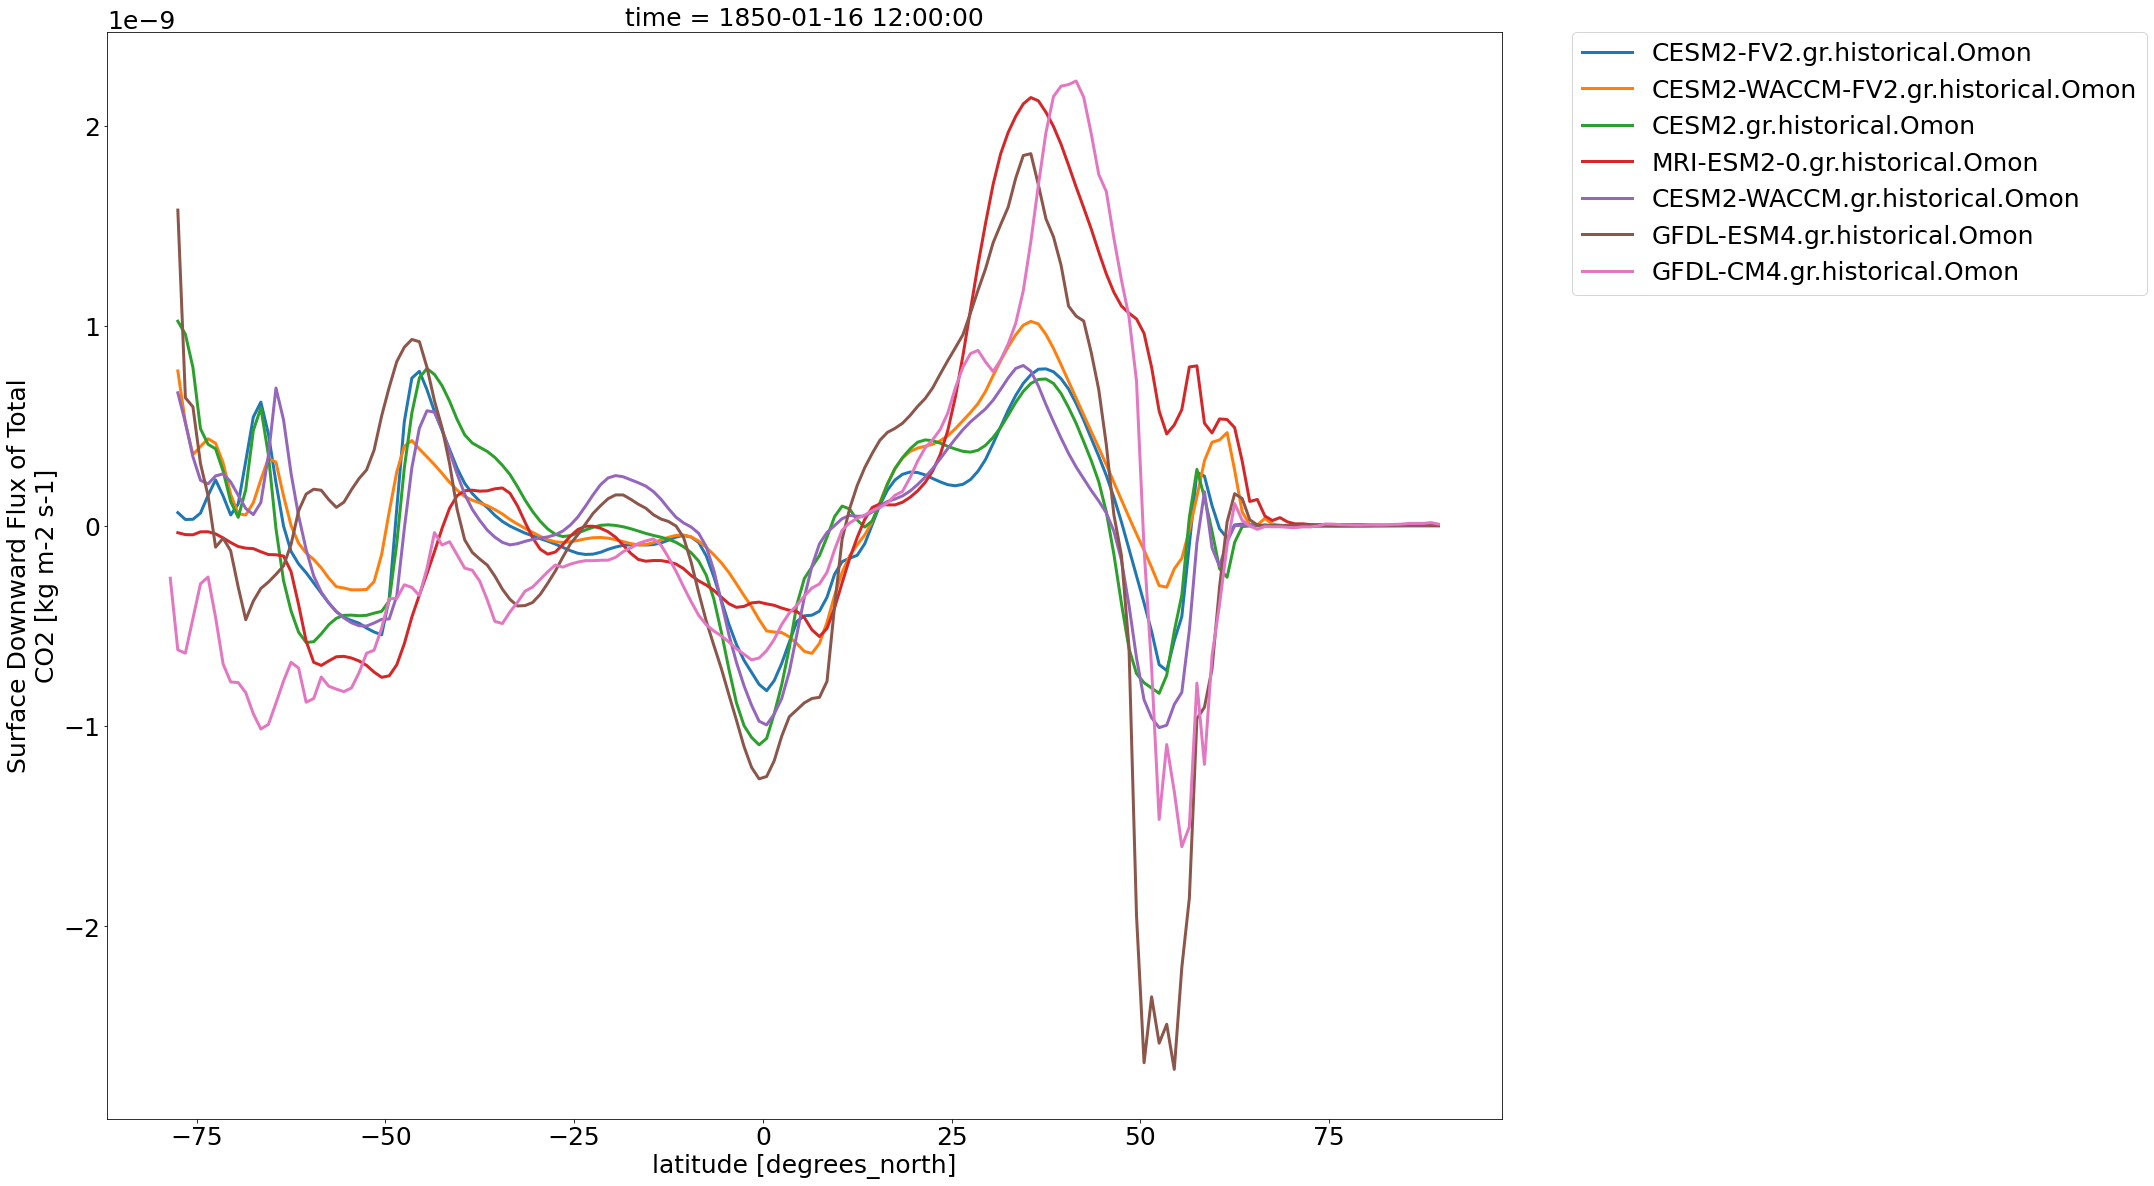

In [42]:
# fig_1, axarr_1 = plt.subplots(nrows = 7, figsize=[18,12])
plt.rc('font', size = 25)
plt.rc('axes', titlesize= 25)    
plt.rc('axes', labelsize= 25)
plt.rc('figure', titlesize=25)

ax_idx = 0
for name, ds in dd_fgco2.items():
    ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True).plot(label = name, lw = 3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.rcParams["figure.figsize"] = (25,20)
    
plt.savefig('fgco2_lineplot_july20.png')


I'd like to add an ensemble mean but i'm not sure how